1. [Import Libraries](#1)
2. [Reading the Dataset](#2)
3. [Data Pre-processing](#3)
4. [Modeling](#4)
    - 4.1. [Logistic Regression](#7)
    - 4.2. [LightGBM](#8)
    - 4.3. [Wrap-up and get the output](#9)
5. [Conclusions](#5)
6. [References](#6)

# 1. Import Libraries <a id = 1> </a>

In [ ]:
import gc

import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

import numpy as np 

import pandas as pd

from scipy import stats

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU

import warnings
warnings.filterwarnings('ignore')

# 2. Reading the Dataset <a id = 2> </a>

#### <a href = 'https://www.kaggle.com/c/santander-customer-transaction-prediction'>Link to the dataset in Kaggle.</a>

In [ ]:
raw_train = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
raw_test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
raw_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
print(f'Shape of training dataset: {raw_train.shape}')
print(f'Shape of testing dataset: {raw_test.shape}')
print(20 * "-")
print(f'Number of NaN values in training dataset: {raw_train.isnull().values.sum()}')
print(f'Number of NaN values in testing dataset: {raw_test.isnull().values.sum()}')
print(20 * "-")
print(f"Number of training values that aren't float64: {sum(raw_train.iloc[:, 2:].dtypes != 'float64')}")
print(f"Number of testing values that aren't float64: {sum(raw_test.iloc[:, 2:].dtypes != 'float64')}")

Shape of training dataset: (200000, 202)
Shape of testing dataset: (200000, 201)
--------------------
Number of NaN values in training dataset: 0
Number of NaN values in testing dataset: 0
--------------------
Number of training values that aren't float64: 0
Number of testing values that aren't float64: 0


# Data Pre-processing <a id = 3> </a>

Text(0.5, 1.0, 'Class distribution')

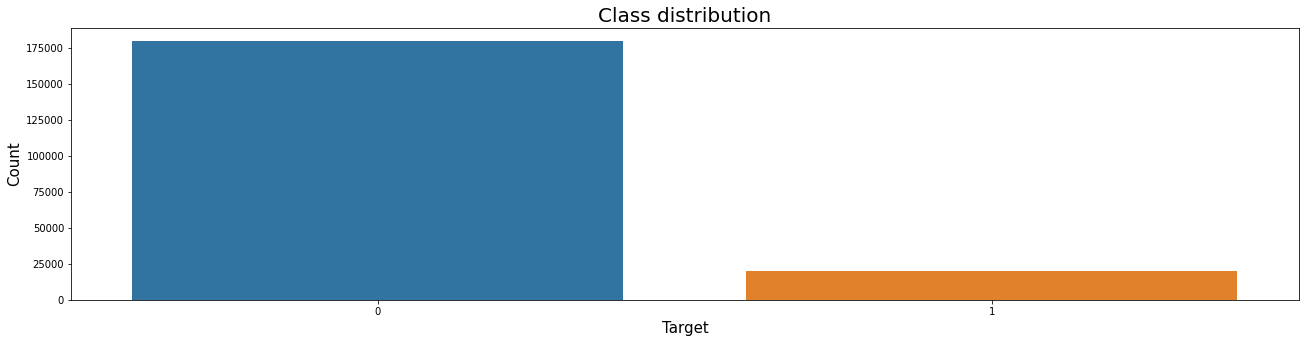

In [ ]:
plt.figure(figsize = (22, 5))
sns.countplot(data = raw_train, x = 'target')
plt.xlabel('Target', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Class distribution', fontsize = 20)

In [ ]:
num_0, num_1 = np.bincount(raw_train['target'])
print(f'Number of samples belonging to class zero: {num_0} ({num_0 / raw_train.shape[0]:0.2%} of total)')
print(f'Number of samples belonging to class one: {num_1} ({num_1 / raw_train.shape[0]:0.2%} of total)')

del num_0, num_1
_ = gc.collect()

Number of samples belonging to class zero: 179902 (89.95% of total)
Number of samples belonging to class one: 20098 (10.05% of total)


In [ ]:
y = raw_train['target']
train_len = len(raw_train)
id_test = raw_test['ID_code']

merged_df = pd.concat([raw_train, raw_test], axis = 0).drop(columns = ['ID_code', 'target'])

del raw_train, raw_test
_ = gc.collect()

merged_df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
merged_minmax = MinMaxScaler().fit_transform(merged_df)
merged_minmax_df = pd.DataFrame(merged_minmax)
merged_minmax_df = merged_minmax_df.add_prefix('var_')

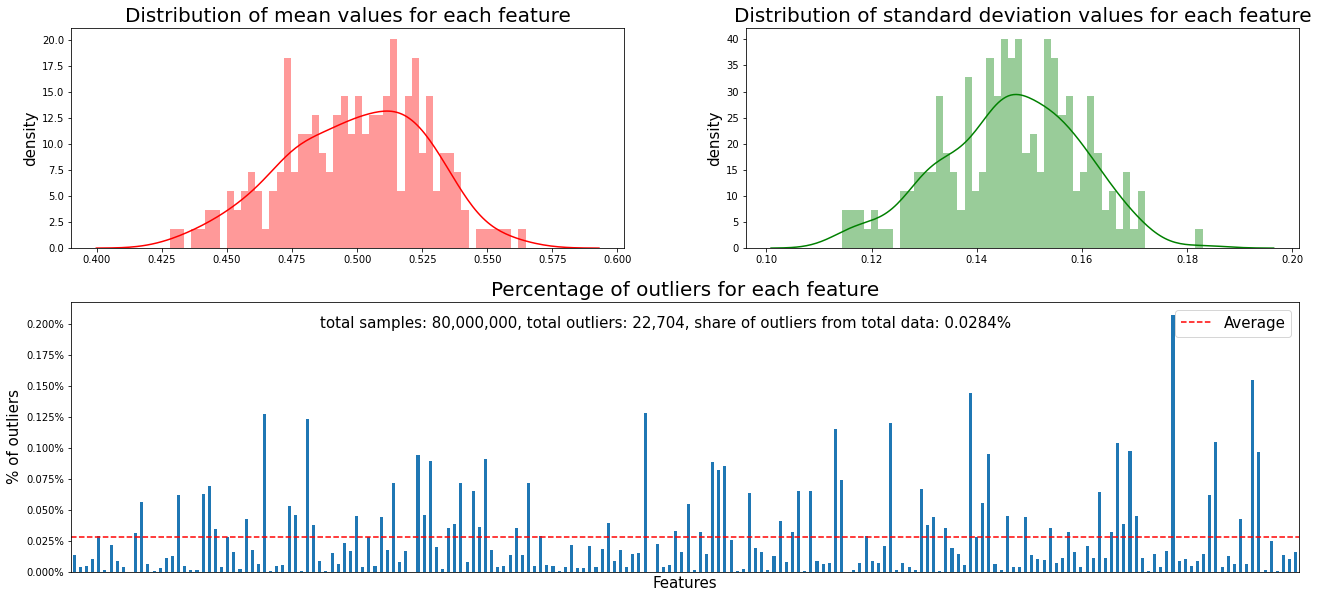

In [ ]:
def stat_detector(df):
    
    '''
    argument:
        df: a DataFrame.
    outputs:
        outlier_mask: 0-1 mask; 0: not outlier, 1: is outlier.
        Three plot about mean values, std values and outliers for each feature. 
    '''
    plt.figure(figsize=(22, 10))
    
    ax1 = plt.subplot2grid((22, 22), (0, 0), rowspan = 9, colspan = 10)
    
    plt.title(f'Distribution of mean values for each feature', fontsize = 20)
    ax1 = sns.distplot(df.mean(), kde = True, bins = 50, color = 'red')
    plt.ylabel('density', fontsize = 15)

    ax2 = plt.subplot2grid((22, 22), (0, 12), rowspan = 9, colspan = 10)
    
    plt.title(f'Distribution of standard deviation values for each feature', fontsize = 20)
    ax2 = sns.distplot(df.std(), kde = True, bins = 50, color = 'green')
    plt.ylabel('density', fontsize = 15)

    ax3 = plt.subplot2grid((22, 22), (11, 0), rowspan = 11, colspan = 22)

    total_data = df.shape[0] * df.shape[1]

    outlier_mask = (np.abs(stats.zscore(df)) > 3.0) * 1
    sum_outlier_col = outlier_mask.sum()
    total_outlier = sum(sum_outlier_col)
    outlier_share = (total_outlier / total_data) * 100
    share_outlier_col = (sum_outlier_col / df.shape[0]) * 100

    ax3 = plt.axhline(y = outlier_share, color = 'red', linestyle = '--', label = 'Average')
    ax3 = share_outlier_col.plot.bar()
    plt.title(f'Percentage of outliers for each feature', fontsize = 20)
    plt.suptitle(f'total samples: {total_data:,}, total outliers: {total_outlier:,}, share of outliers from total data: {outlier_share:0.3}%',
                 y = 0.48, fontsize = 15)
    plt.xlabel('Features', fontsize = 15)
    plt.ylabel('% of outliers', fontsize = 15)
    plt.legend(['Average'], fontsize = 15)
    plt.xticks([])
    ax3.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 3))

    return outlier_mask

_ = stat_detector(merged_minmax_df)

In [ ]:
merged_minmax_df.head(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0.394711,0.324824,0.568059,0.388041,0.550670,0.467301,0.465762,0.578688,0.270395,0.247420,...,0.537807,0.342943,0.568958,0.448173,0.510471,0.291973,0.678981,0.412164,0.320222,0.564556
1,0.511048,0.428639,0.681235,0.410417,0.628408,0.795039,0.546339,0.487471,0.660911,0.573056,...,0.630884,0.536531,0.523717,0.756190,0.349865,0.743892,0.686614,0.447856,0.595713,0.609337
2,0.380425,0.483777,0.578061,0.599690,0.474941,0.471310,0.758477,0.403860,0.270429,0.276041,...,0.493407,0.643141,0.448960,0.448000,0.670521,0.856859,0.236337,0.365293,0.416170,0.586451
3,0.491161,0.507140,0.396562,0.546993,0.647586,0.616796,0.581965,0.417350,0.224846,0.595326,...,0.538713,0.383085,0.370986,0.439205,0.744819,0.406918,0.346810,0.685901,0.576626,0.448188
4,0.435886,0.533434,0.624133,0.504796,0.621079,0.702806,0.597644,0.605921,0.811883,0.516413,...,0.365804,0.629275,0.299888,0.697737,0.238566,0.382291,0.557507,0.560948,0.577995,0.450972


In the first step, the dataset is scaled. Then, 64 features are added to the dataset in two steps. Data obtained from PCA is first added, followed by data received from Denoising Autoencoder. 

|method|Number of initial features|Number of features after transformation|
|:-:|:-:|:-:|
|Scaled dataset|200|200|
|Scaled dataset + PCA|200|232|
|Scaled dataset + PCA + DAE|232|264|


In [ ]:
merged_pca = PCA(n_components = 0.2, random_state = 0).fit_transform(merged_minmax)
merged_pca_scaled = MinMaxScaler().fit_transform(merged_pca)
merged_pca_df = pd.DataFrame(merged_pca_scaled)
merged_pca_df = merged_pca_df.add_prefix('pca_')
print(f'Shape of dataset after transformation using PCA: {merged_pca.shape}')

merged_minmax_pca_df = pd.concat([merged_minmax_df, merged_pca_df], axis = 1)
print(f'Shape of dataset after concatenating: {merged_minmax_pca_df.shape}\n')

del merged_minmax, merged_minmax_df, merged_pca, merged_pca_scaled #merged_minmax_df
_ = gc.collect()

merged_minmax_pca_df.head(2)

Shape of dataset after transformation using PCA: (400000, 32)
Shape of dataset after concatenating: (400000, 232)



,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31
0,0.394711,0.324824,0.568059,0.388041,0.550670,0.467301,0.465762,0.578688,0.270395,0.247420,...,0.477187,0.728156,0.445331,0.735298,0.346019,0.615466,0.635954,0.540962,0.260101,0.458066
1,0.511048,0.428639,0.681235,0.410417,0.628408,0.795039,0.546339,0.487471,0.660911,0.573056,...,0.513585,0.559845,0.690256,0.522545,0.476781,0.498248,0.303713,0.371866,0.452967,0.704266


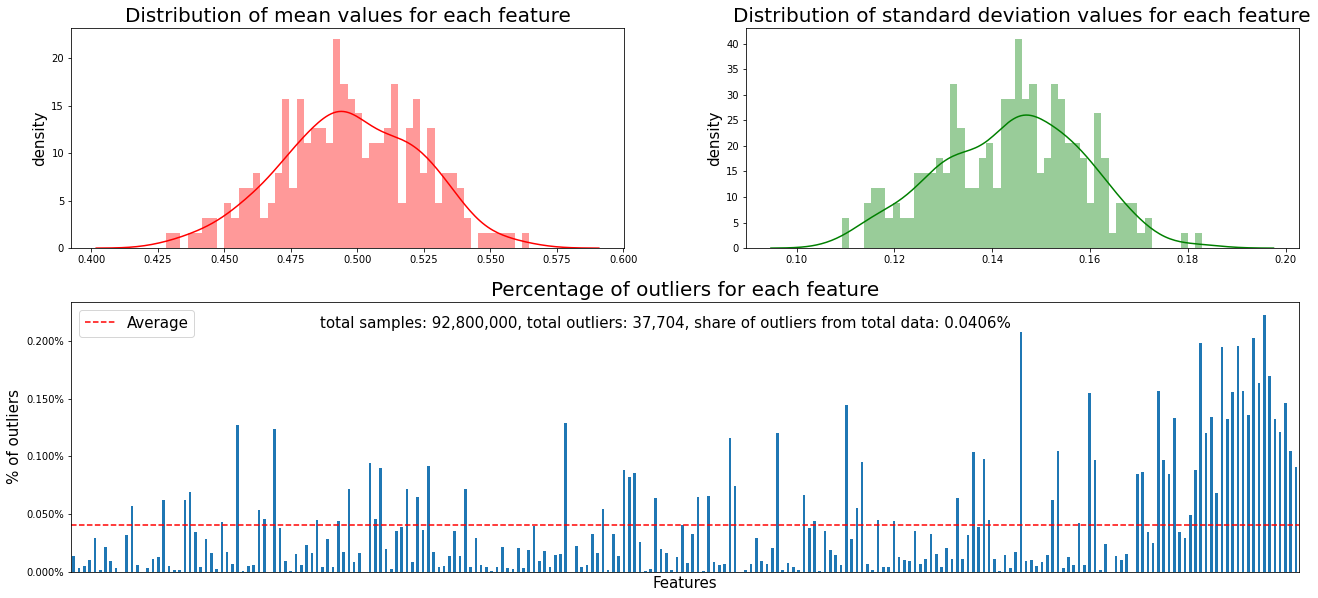

In [ ]:
_ = stat_detector(merged_minmax_pca_df)

In [ ]:
input_dim = merged_pca_df.shape[1] 

encoder_decoder = Sequential(
    [
        Dense(64, input_shape = (input_dim, )),
        BatchNormalization(),
        LeakyReLU(),
        Dense(32),
        BatchNormalization(),
        LeakyReLU(),
        Dense(16),
        Dense(32),
        BatchNormalization(),
        LeakyReLU(),
        Dense(64),
        BatchNormalization(),
        LeakyReLU(),
        Dense(input_dim, activation = 'linear')
        
    ]
)

auto_encoder = Model(inputs = encoder_decoder.input, outputs = encoder_decoder.output)
auto_encoder.summary()

2022-05-19 16:40:37.081627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0     

2022-05-19 16:40:37.088001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 16:40:37.088717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 16:40:37.090346: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 16:40:37.090662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
auto_encoder.compile(loss = 'mse', optimizer = 'adam')

epochs = 10
index_merged_pca = np.random.choice(np.arange(merged_pca_df.shape[0]), int(merged_pca_df.shape[0] / 4))

auto_encoder_history = auto_encoder.fit(
    merged_pca_df.iloc[index_merged_pca].values, #Can we add noise? + np.random.normal(0.5, 0.15, size = merged_pca_df.iloc[index_merged_pca].shape)
    merged_pca_df.iloc[index_merged_pca].values,
    batch_size = 32,
    epochs = epochs
)

2022-05-19 16:40:39.644377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3125/3125 [==============================] - 12s 3ms/step - loss: 0.0209
Epoch 2/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0095
Epoch 3/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0087
Epoch 4/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0084
Epoch 5/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0082
Epoch 6/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0082
Epoch 7/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0081
Epoch 8/10
3125/3125 [==============================] - 9s 3ms/step - loss: 0.0081
Epoch 9/10
3125/3125 [==============================] - 9s 3ms/step - loss: 0.0080
Epoch 10/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.0080


In [ ]:
merged_dae = auto_encoder.predict(merged_pca_df.values)
merged_dae_df = pd.DataFrame(merged_dae)
merged_dae_df = merged_dae_df.add_prefix('dae_')
merged_pca_dae = pd.concat([merged_minmax_pca_df, merged_dae_df], axis = 1)

del merged_dae, merged_pca_df, merged_dae_df, auto_encoder_history, index_merged_pca
_ = gc.collect()

merged_pca_dae.head(2)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,dae_22,dae_23,dae_24,dae_25,dae_26,dae_27,dae_28,dae_29,dae_30,dae_31
0,0.394711,0.324824,0.568059,0.388041,0.550670,0.467301,0.465762,0.578688,0.270395,0.247420,...,0.438449,0.497913,0.470524,0.494273,0.467798,0.475881,0.494015,0.503242,0.372046,0.487442
1,0.511048,0.428639,0.681235,0.410417,0.628408,0.795039,0.546339,0.487471,0.660911,0.573056,...,0.459634,0.489418,0.463228,0.502017,0.467079,0.513511,0.449841,0.474393,0.483466,0.743120


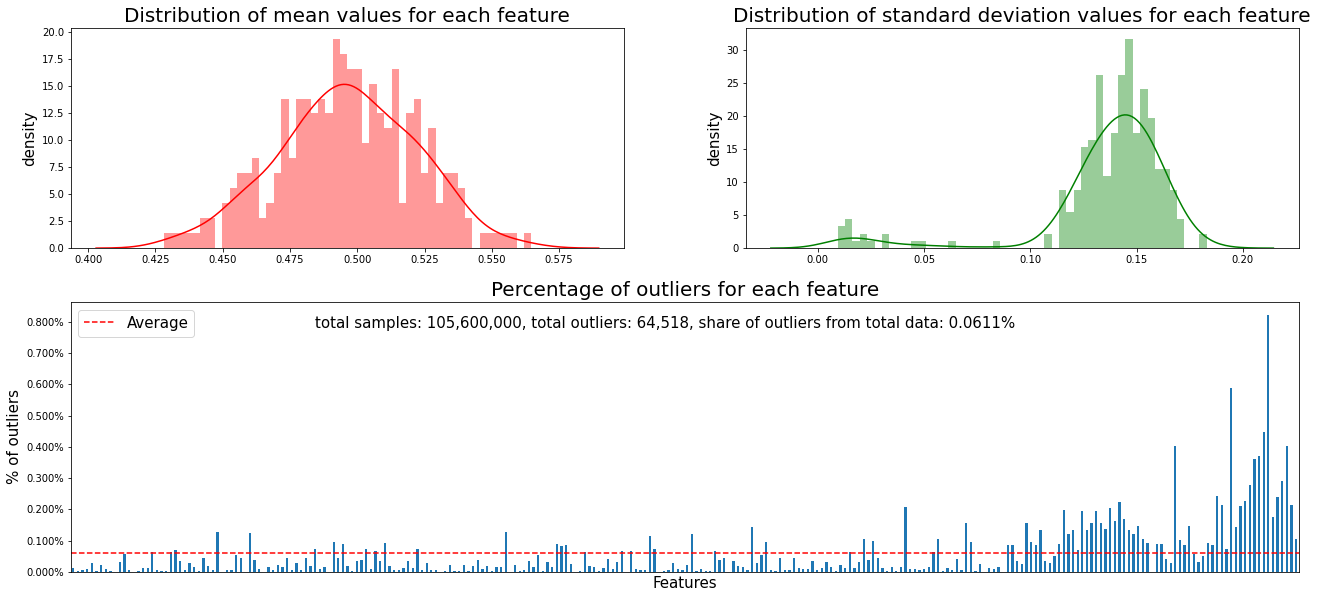

In [ ]:
_ = stat_detector(merged_pca_dae)

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(merged_pca_dae[:train_len], y, test_size = 0.3, shuffle = True, stratify = y)

stnd_scaler = StandardScaler().fit(X_train)
X_train_scaled = stnd_scaler.transform(X_train)
X_dev_scaled = stnd_scaler.transform(X_dev)
X_test_scaled = stnd_scaler.transform(merged_pca_dae[train_len:])

del merged_pca_dae, stnd_scaler
_ = gc.collect()

# 4. Modeling <a id = 4> </a>

## 4.1. Logistic Regression <a id = 7> </a>

In [ ]:
param_grid_lr = {
    'C': [0.001, 0.01]
}

lr = LogisticRegression(penalty = 'l2', solver = 'sag', class_weight = 'balanced', random_state = 0)

grid_lr = GridSearchCV(
    estimator = lr, 
    param_grid = param_grid_lr, 
    scoring='roc_auc',
    cv = 3, 
    refit = True, 
    n_jobs = -1
)

grid_lr.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_lr.best_params_}")

Best parameters: {'C': 0.001}


In [ ]:
y_pred_lr = grid_lr.predict_proba(X_dev_scaled)[:, 1]
y_pred_lr_final = grid_lr.predict_proba(X_test_scaled)[:, 1]

print(f'AUC score for dev dataset using LogisticRegression: {roc_auc_score(y_dev, y_pred_lr):0.3f}')

AUC score for dev dataset using LogisticRegression: 0.861


## 4.2. LightGBM <a id = 8> </a>

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective = 'binary',
    learning_rate = 0.07,
    num_leaves = 20,
    n_estimators = 500, 
    max_depth = 8,
    class_weight = 'balanced',
    subsample = 1,
    colsample_bytree = 1,
    metric = 'auc',
    device = 'gpu',
    gpu_platform_id = 0,
    gpu_device_id = 0,
    random_state = 0                          
)

param_grid_lgb = {
    'reg_alpha': [0.1, 1],
    'reg_lambda': [0.1, 1]
}

grid_lgb = GridSearchCV(
    estimator = lgb_model, 
    param_grid = param_grid_lgb,
    scoring='roc_auc',
    cv = 3, 
    refit = True, 
    n_jobs = -1
)

grid_lgb.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_lgb.best_params_}")

Best parameters: {'reg_alpha': 0.1, 'reg_lambda': 0.1}


In [ ]:
y_pred_lgb = grid_lgb.predict_proba(X_dev_scaled)[:, 1]
y_pred_lgb_final = grid_lgb.predict_proba(X_test_scaled)[:, 1]

print(f'AUC score for dev dataset using LightGBM: {roc_auc_score(y_dev, y_pred_lgb):0.3f}')

AUC score for dev dataset using LightGBM: 0.890


## 4.3. Wrap-up and get the output <a id = 9> </a>

(0.7, 0.92)

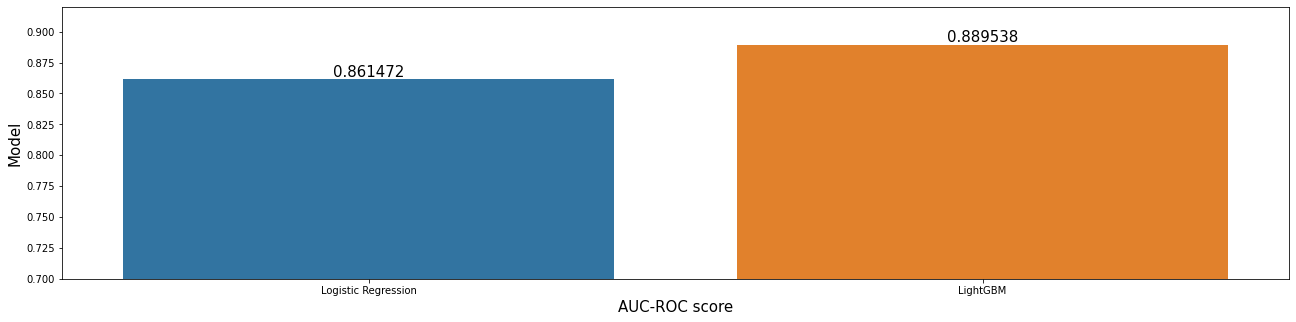

In [ ]:
AUC_df = pd.DataFrame(
    dict(
    model = ['Logistic Regression', 'LightGBM'],
    score = [roc_auc_score(y_dev, y_pred_lr), roc_auc_score(y_dev, y_pred_lgb)]
    )
)


plt.figure(figsize = (22, 5))
ax = sns.barplot(data = AUC_df, x = 'model', y = 'score')
ax.bar_label(ax.containers[0], fontsize = 15)
ax.set_xlabel('AUC-ROC score', fontsize = 15)
ax.set_ylabel('Model', fontsize = 15)
ax.set_ylim([0.7, 0.92])

In [ ]:
output = pd.DataFrame(
    {
    'ID_code': [],
    'target': []   
    }
)

output['ID_code'] = id_test
output['target'] = y_pred_lgb_final

output

,ID_code,target
0,test_0,0.327899
1,test_1,0.778603
2,test_2,0.562155
3,test_3,0.603873
4,test_4,0.221265
...,...,...
199995,test_199995,0.101695
199996,test_199996,0.047033
199997,test_199997,0.019210
199998,test_199998,0.366847


In [ ]:
output.to_csv('./submission.csv', index = False)

# 5. Conclusions <a id = 5> </a>

It is assumed that the optimal error rate is 0.92 (best AUC-ROC). Considering that our best AUC-ROC is 0.89, there is a considerable bias that can be avoided.</br>
Besides these, I also just scaled the dataset and trained it with the LightGBM model without any further pre-processing. I obtained an AUC-ROC score of 0.88! In other words, all this pre-processing on the notebook hasn't really improved the score.Besides these, I also just scaled the dataset and trained it with the LightGBM model without any further pre-processing. I obtained an AUC-ROC score of 0.88! In other words, all this pre-processing on the notebook hasn't really improved the score.

# 6. References <a id = 6> </a>

- <a href = 'https://ekamperi.github.io/machine%20learning/2021/01/21/encoder-decoder-model.html'>The encoder-decoder model as a dimensionality reduction technique</a>